In [1]:
!pip install selenium
!pip install BeautifulSoup
!pip install wordcloud
!pip install matplotlib

  Using cached https://files.pythonhosted.org/packages/1e/ee/295988deca1a5a7accd783d0dfe14524867e31abb05b6c0eeceee49c759d/BeautifulSoup-3.2.1.tar.gz
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "C:\Users\parkj\AppData\Local\Temp\pip-install-26sbg2vt\BeautifulSoup\setup.py", line 22
        print "Unit tests have failed!"
                                      ^
    SyntaxError: Missing parentheses in call to 'print'. Did you mean print("Unit tests have failed!")?
    
    ----------------------------------------


Command "python setup.py egg_info" failed with error code 1 in C:\Users\parkj\AppData\Local\Temp\pip-install-26sbg2vt\BeautifulSoup\


In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import time
import csv
%matplotlib inline

class instagram_Hashtag_Crawler:
    """
        인스타그램 해시태그 데이터 수집
    """
    def follow_Crawling(self, path = 'C:/Users/parkj/chromedriver/chromedriver.exe'): # 팔로우한 계정 크롤링
        """
            인스타그램 팔로우 계정 데이터 수집
            
            path: 크롬드라이버 저장 위치
        """
        self.path = path # Chrome Webdriver Path
        
        account_id = [] # 계정 ID 넣을 list
        
        driver = webdriver.Chrome(path) # Chrome webdriver path
        driver.get('https://www.instagram.com') # 사이트 주소
        time.sleep(1) # 1초 슬립
        
        driver.find_element_by_css_selector('p.izU2O > a').click() # 인스타그램 로그인 버튼 클릭
        time.sleep(1)
        
        driver.find_element_by_name('username').send_keys('hashtagcrawler@gmail.com') # 계정 ID 입력
        driver.find_element_by_name('password').send_keys('dkdlel12') # 계정 Password 입력
        
        driver.find_element_by_xpath("//button[@class = '_0mzm- sqdOP  L3NKy       ']").click() # 로그인 하기 버튼 클릭
        time.sleep(3) # 3초 슬립
        
        driver.find_element_by_xpath("//button[@class = 'aOOlW  bIiDR  ']").click() # 알림 설정 버튼 클릭
        driver.find_element_by_xpath("//span[@class = 'glyphsSpriteUser__outline__24__grey_9 u-__7']").click() # 내 정보 클릭
        time.sleep(4) # 4초 슬립
        
        driver.find_elements_by_css_selector('a.-nal3 ')[1].click() # 팔로우 버튼 클릭
        time.sleep(1)
        
        scroll = driver.find_element_by_class_name('isgrP') # 스크롤 범위
        driver.execute_script("arguments[0].scrollTop = arguments[0].scrollHeight", scroll) # 스크롤 맨 밑으로 내리기
        time.sleep(1)
        
        # 스크롤 절반 올리기
        jsScript = """
        function move_up(element) {
            element.scrollTop = element.scrollTop - 500;
        }

        function move_down(element) {
            console.log('Position before: ' + element.scrollTop);
            element.scrollTop = element.scrollTop + 1000;
            console.log('Position after: ' + element.scrollTop);
        }

        move_up(arguments[0]);
        """
        
        driver.execute_script(jsScript, scroll) # 스크롤 절반 올리기
        time.sleep(1)
        
        # 스크롤 다시 계속 내리기
        try:
            for i in range(10): # 스크롤 10번 내림
                driver.execute_script("arguments[0].scrollTop = arguments[0].scrollHeight", scroll)
                time.sleep(1)
        except:
            print('error')
            
        time.sleep(3)
        
        html = driver.page_source # Html 소스코드 가져오기
        dom = BeautifulSoup(html, 'html.parser') # BeautifulSoup 모듈로 Html 객체구조 변환
            
        account_id_list = driver.find_elements_by_xpath("//a[@class = 'FPmhX notranslate _0imsa ']") # 계정 ID 경로
        
        for j in account_id_list:
            account_id.append(j.text) # 계정 ID 경로 텍스트로 리스트 삽입
            
        driver.close() # 브라우져 종료
            
        return account_id
    
    def hashtag_Crawling(self, account_id_lists, is_date, path = 'C:/Users/parkj/chromedriver/chromedriver.exe'):
        """
            인스타그램 해시태그 데이터 수집
            
            account_id_lists: 계정ID 데이터
            is_date: 데이터 수집할 날짜
                    예) 2019년 1월(띄어쓰기 지켜야함)
            path: 크롬드라이버 설치 위치
        """
        self.account_id_lists = account_id_lists # 계정 ID
        self.is_date = is_date # 크롤링 할 달
        self.path = path # Chrome Webdriver Path
        
        tag_data = [] # 해시태그 소스코드 저장
        words = [] # 텍스트로 추출 후 저장
        words_list = [] # 해시태그만 저장
        
        for i in range(len(account_id_lists)):
            driver = webdriver.Chrome(path) # Chrome Webdriver Path
            driver.get('https://www.instagram.com/' + account_id_lists[i]) # 인스타그램 계정 URL
            
            driver.find_element_by_xpath("//div[@class = '_9AhH0']").click() # 계정 첫번째 게시물 클릭
            
            while True:
                try:
                    time.sleep(3) # 3초 슬립
                    html = driver.page_source # Html 소스 코드 가져오기
                    dom = BeautifulSoup(html, 'html.parser') # BeautifulSoup 모듈로 Html 객체구조 변환
                    
                    date = driver.find_element_by_class_name('_1o9PC').get_attribute('title')[:8] # 게시물 날짜 년, 월까지만 크롤링
                    
                    if is_date == date: # 게시물 날짜가 입력날짜와 같으면 실행
                        tag_data += dom.select('div.C4VMK > span > a') # 해시태그 저장
                        
                        driver.find_element_by_xpath("//a[@class = 'HBoOv coreSpriteRightPaginationArrow']").click() # 다음 버튼 클릭
                    else: # 날짜가 다르면
                        driver.find_element_by_xpath("//a[@class = 'HBoOv coreSpriteRightPaginationArrow']").click() # 다음 버튼 클릭
                except:
                    driver.close() # 브라우져 종료
                    break
                    
            time.sleep(1)
            
        for j in tag_data:
            words.append(j.text) # 텍스트로 추출
            
        for x in words:
            if x[0] == '#': # 해시태그와 계정태그 중 해시태그만 추출
                words_list.append(x)
                
        return words_list
    
    def save_csv(self, date, tags):
        """
            인스타그램 해시태그 데이터 CSV파일로 저장
            
            date: 저장할 파일 이름
                (예: 2019_1)
            tags: 인스타그램 해시태그 데이터
        """
        self.date = date # csv파일 저장 이름
        self.tags = tags # 해시태그 데이터
        
        tc = Counter(tags) # 빈도수
        tags_count = dict(tc) # 딕셔너리 구조로 바꿈
        
        with open(date + '_instagram_Hashtag.csv', 'w', encoding = 'utf-8', newline = '') as f: # csv파일 저장
            header = ['해시태그', '빈도수']
            writer = csv.DictWriter(f, fieldnames = header)
            
            writer.writeheader()
            
            for i, j in tags_count.items():
                writer.writerow({'해시태그' : i, '빈도수' : j})
                
    def wordcloud_Plot(self, words_list, save_file_name):
        """
            수집한 해시태그 데이터 시각화
            
            words_list: 수집한 해시태그 데이터
            save_file_name: 시각화 파일 저장 이름
                            (예: wordcloud)
        """
        self.words_list = words_list # 해시태그 리스트
        self.save_file_name = save_file_name # wordcloud 저장 이름
        
        f = open('C:/Users/parkj/wordcloud_data.txt', 'w')
        
        for i in range(len(words_list)):
            f.write(words_list[i] + '\n')   
        f.close()
        
        text = open('C:/Users/parkj/wordcloud_data.txt').read()
        # 워드클라우드로 변환
        wordcloud = WordCloud(max_font_size = 30, font_path = 'C:/Windows/Fonts/BatangChe.ttf', background_color = 'white').generate(text)
        
        plt.figure(figsize = (40, 40)) # 시각화 사이즈
        plt.imshow(wordcloud, interpolation = 'bilinear') # 시각화 종류
        plt.axis('off') # x, y축 이름 제거
        plt.savefig(save_file_name) # 저장

In [3]:
instagram = instagram_Hashtag_Crawler()

In [4]:
account_id_lists = instagram.follow_Crawling()

In [5]:
account_id_lists

['miyayeah',
 'sooyaaa__',
 'lalalalisa_m',
 'roses_are_rosie',
 'seungriseyo',
 'xxjjjwww',
 'fromyg',
 'maetamong',
 'w_n_r00',
 'daraxxi',
 'blobyblo',
 'crush9244',
 'satgotloco',
 'hyunah_aa',
 'junoflo',
 'woodie_gochild',
 'younghotyellow94',
 'h1ghrmusic',
 'bsk_world',
 'blackpinkofficial',
 'jennierubyjane',
 'jennie_kjn',
 'code_kunst',
 'bewhy.meshasoulja',
 'nasungcityboy',
 'wejustmusic',
 'thisloop',
 'jparkitrighthere',
 'hashblanccoa',
 'callmegray',
 'aomgofficial',
 'jelly_jilli',
 'ph1boyyy',
 'paloaltongue',
 'woozico0914',
 'thequiett',
 'munchinthepool',
 'dok2gonzo',
 'noahmik',
 'realllllmino',
 'kiff_websterb',
 'changmo_',
 'itsjustswings',
 'kidcozyboy',
 'dickidsyoungb',
 'noelcozyboy',
 'yohanheaven',
 'osshun_gum',
 'jvckiwai',
 'hankyungsoo',
 '______isu______',
 'deer_nose',
 'jazzman_dh',
 'yangdail',
 'tenomahj',
 'henryl89',
 'lilyiu_',
 'giriboy91',
 'chungha_official']

In [6]:
tags = instagram.hashtag_Crawling(account_id_lists, '2019년 1월')

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//div[@class = '_9AhH0']"}
  (Session info: chrome=71.0.3578.98)
  (Driver info: chromedriver=2.45.615291 (ec3682e3c9061c10f26ea9e5cdcf3c53f3f74387),platform=Windows NT 10.0.17134 x86_64)


In [ ]:
tags

In [9]:
instagram.save_csv('2019_01', tags)

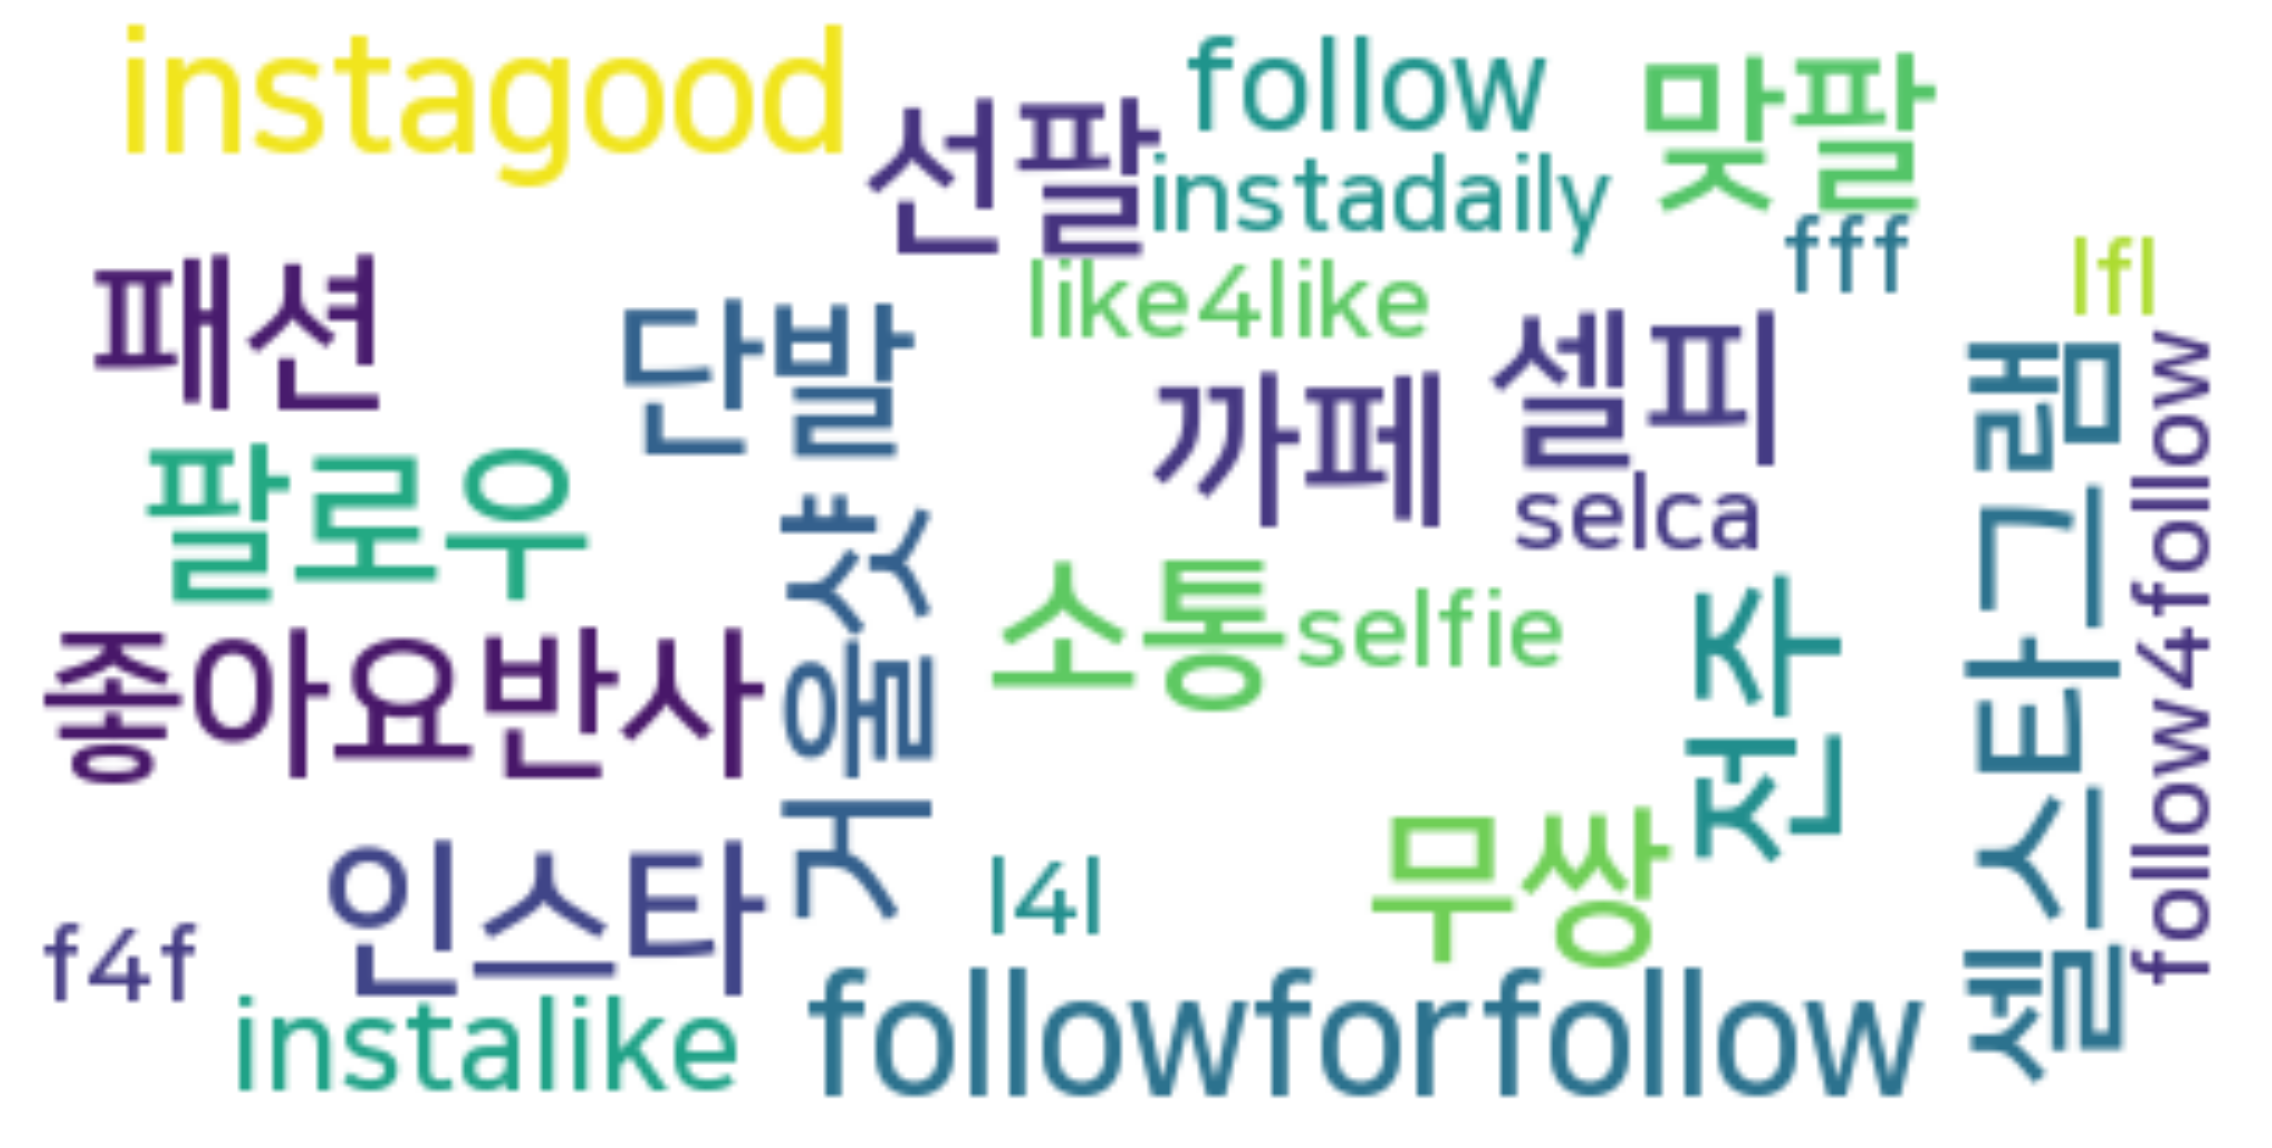

In [12]:
instagram.wordcloud_Plot(tags, 'instagram_wordcloud')